<h3 align="center">Homework 3</h3> 

<h3 align="center">Danny D'Agostino</h3> 

<h3 align="center">Number : 1247958</h3> 

In [66]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Image
img1 = np.asarray(Image.open('/home/danny/Università/Optimization Methods for Machine Learning/Homework3/car1/obj23__260.png'))
img2 = np.asarray(Image.open('/home/danny/Università/Optimization Methods for Machine Learning/Homework3/car2/obj100__220.png'))

In this homework we use the COIL-100 dataset of 100 visual object categories. The dataset contains 70000 128x128 colored images with subtracted background. The two classes are: 

A red sports car : 

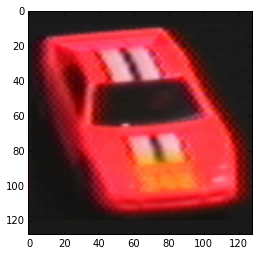

In [3]:
iview = plt.imshow(img1)

An old truck (i think) :

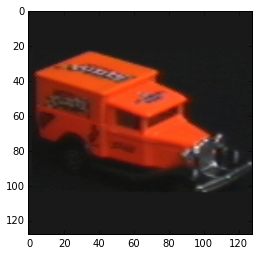

In [4]:
iview = plt.imshow(img2)

Every images give me a 3-d array, where the last dimension specifies the color of
a pixel in RGB. After converting every image in a 49152-dimensional vector, The total number of samples are 144 (72 for every class). 
This type of dataset has a really high dimension and methods like SVM can suffer in this case, but we can reduce the dimension of the dataset with principal component analysis (PCA). 
Principal component analysis is a tecniques that seeks a r-dimensional basis that best captures the variance in the data. The direction with the largest projected variance ( or the one that minimizes the mean squared error ) is called the first principal component. The orthogonal direction that captures the second largest projected variance is called the second principal component, and so on. All this stuff is computed by calcuate from the covarance matrix the eigenvectors from the dominant eigenvalues. 
For the optimization routines we use CVXOPT (http://cvxopt.org/), it is a python library for solve convex optimization problems using an interior point method.
Finally i use both K-fold cross-valdation (stratified and shuffled) and the grid-search to have a significative statistical results and for find the best hyperparameters.

The result from the primal formulation of the SVM is : 

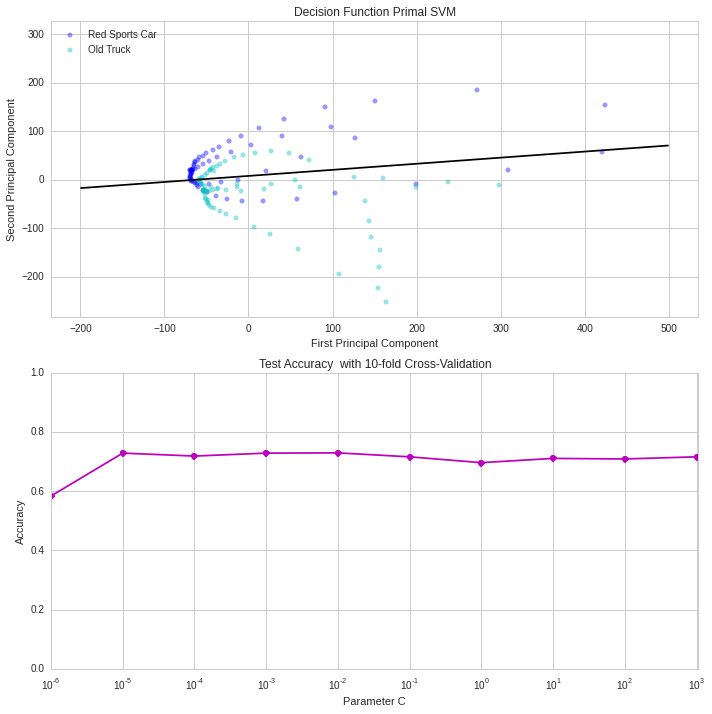

([0.58392857142857135, 0.72857142857142854, 0.71875, 0.72857142857142865, 0.72946428571428568, 0.71607142857142869, 0.69642857142857151, 0.71071428571428563, 0.70892857142857146, 0.71607142857142847], 'Average Times Optimization Routines 0.0165252590179')


In [82]:
# -*- coding: utf-8 -*-
import numpy as np
import Image
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from timeit import default_timer as timer
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from cvxopt import matrix, solvers
from cvxopt.solvers import qp

#### DATA PREPROCESSING #####

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    #img_data3 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/class3/obj65__'+str(k)+'.png'))
    if k==0:
        im1 = img_data1
        im2 = img_data2
        #im3 = img_data3
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    #x3 = img_data3.ravel()
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
    #X.append(x3)
    #Y.append(2)  
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)


def primal_svm(X,y,param_C):
    times = []
    accuracies = []
    for C in param_C:
        acc=[]
        kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
        for train_index, test_index in kf1:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
            n_s = len(X_train)
            n_f = len(X_train[0])
            
            m = np.eye(n_s)
            m = np.dot(-1,m)
            mz = np.zeros((n_s,n_f +1))
            c = np.column_stack((mz,m))
            b = np.ones(n_s)
            y1 = np.dot(-1,y_train)
            G1 = np.column_stack((X_train,b))
            m1 = G1*y1[:, np.newaxis] 
            G2 = np.column_stack((m1,m))
            G = np.vstack((G2,c))

            h1 = np.ones(n_s)
            h1 = np.dot(-1,h1)
            h2 = np.zeros(n_s)
            h = np.concatenate((h1,h2))

            Q = np.zeros((n_s+n_f+1,n_s+n_f+1))
            for i in range(n_f):
                Q[i,i] = 1
            
            p1 = C*np.ones(n_s)
            p2 = np.zeros(n_f+1) 
            p = np.concatenate((p2,p1))
            
            Q = matrix(Q)
            h = matrix(h)
            p = matrix(p)
            G = matrix(G)
            solvers.options['show_progress'] = False
            start = timer()
            sol=solvers.qp(Q,p,G, h)
            end = timer()
            time = end - start
            times.append(time)
            w = [sol['x'][0],sol['x'][1]]
            b = sol['x'][2]

            y_pred = []
            for i in range(len(X_test)):
                p = np.inner(w,X_test[i])+b
                yp = np.sign(np.inner(w,X_test[i])+b)
                y_pred.append(yp)
            acc.append(accuracy_score(y_test,y_pred))
        K_f_acc = sum(acc)/len(acc)
        accuracies.append(K_f_acc)
    plot_decision_function(w,b,X,y,accuracies,param_C)
    return accuracies,'Average Times Optimization Routines '+str(sum(times)/len(times))

def plot_decision_function(w,b,X,y,accuracies,param_C):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(211)
    D = np.column_stack((X,y))
    class1 = D[D[:, 2] == 1]
    class2 = D[D[:, 2] == -1]
    colors = ['b', 'c']
    l  = plt.scatter(class1[:,0], class1[:,1], marker='o', color=colors[0],alpha=0.4)
    a  = plt.scatter(class2[:,0], class2[:,1], marker='o', color=colors[1],alpha=0.4)
    z1 = np.linspace(-200, 500)
    z2 = np.linspace(-200, 300)[:, None]
    ax.contour(z1, z2.ravel(), w[0]*z1 + w[1]*z2 + b, [0],colors = 'k')
    ax.legend((l,a),("Red Sports Car", "Old Truck"),loc ='upper left')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title('Decision Function Primal SVM')

    ax2 = fig.add_subplot(212)
    ax2.set_xticks(param_C,minor=True)                                                       
    ax2.set_xticks(accuracies, minor=False)                                           
    ax2.set_xscale('log', nonposy='clip')
    ax2.set_autoscaley_on(False)
    ax2.set_autoscalex_on(True)
    ax2.plot(param_C,accuracies,color='m', label='Accuracy Test Set',marker = 'o')
    ax2.margins(0.05)
    ax2.set_xlabel('Parameter C')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy  with 10-fold Cross-Validation')
    fig.tight_layout()
    sns.set_style("whitegrid")
    
    plt.show()
    
print(primal_svm(X,y,np.logspace(-6, 3, 10)))


The two classes are clearly not linearly separable, the linear SVM is too simple to classify this kind of data and we underfit, infact we achieve the maximum test accuracy  is of 72%.

Now we compute the algorithm on the dual version of the SVM where we can use the Gaussian kernel function for classify not linearly separable dataset. We know that SVM's are one of the most powerful approaches for classification, but only if we find the best combination of the hyperparameters. Using the grid-search we can see the results:

In [21]:
# -*- coding: utf-8 -*-
import numpy as np
import Image
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import product
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from timeit import default_timer as timer
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from cvxopt import matrix, solvers
from cvxopt.solvers import qp


#### DATA PREPROCESSING #####

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    #img_data3 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car3/obj15__'+str(k)+'.png'))
    if k==0:
        im1 = img_data1
        im2 = img_data2
        #im3 = img_data3
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    #x3 = img_data3.ravel()
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
    #X.append(x3)
    #Y.append(2)  
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)
##X = np.array([[0,0],[1,1],[2,2]])
##y = np.array([1,-1,1])

def dual_svm(X,y):
    pairwise_dists = squareform(pdist(X, 'sqeuclidean'))
    accuracies = []
    times = []
    #param_C = np.logspace(0, 3, 4)
    #param_gamma = np.logspace(-7, -4, 4)
    param_C = [100]
    param_gamma = [0.0001]
    name = raw_input('kernel type (gaussian or linear) ? : ')
    kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
    
    if name == 'gaussian':
        for tupla in itertools.product(param_C,param_gamma):
            acc = []
            C = tupla[0]
            gamma = tupla[1]
            for train_index, test_index in kf1:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
            
                n_s = len(X_train)
                n_f = len(X_train[0])
                Q = np.zeros((n_s,n_s))
                
                K = gaussian_kernel(X_train,gamma)
                for i in range(len(Q)):
                    for j in range(len(Q[0])):
                        Q[i,j] = np.inner(y_train[i],y_train[j])*K[i,j]
        
                p = -np.ones((n_s,1))
                
                b = np.array([[0.0]])
                
                A = y_train[np.newaxis]
                A = np.array(A,dtype=float)
                
                G1 = np.eye(n_s)
                G2 = -np.eye(n_s)
                G = np.vstack((G1,G2))
                
                h = np.zeros((2*n_s,1))
                
                h[:n_s] = C
                
                Q = matrix(Q)
                h = matrix(h)
                p = matrix(p)
                G = matrix(G)
                A = matrix(A)
                b = matrix(b)
                solvers.options['show_progress'] = False
                start = timer()
                sol=solvers.qp(Q,p,G,h,A,b)
                end = timer()
                time = end - start
                times.append(time)
                alfa = list(sol['x'])

                spv_indices = [i for i in range(n_s) if alfa[i] > 0]
                nospv_indices = [i for i in range(n_s) if alfa[i] < C]
                S = len(spv_indices)
                mIndices = [i for i in range(n_s) if 0 < alfa[i] < C]
                M = len(mIndices)
                b = sum([y_train[j] - sum([alfa[i] * y_train[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)

                y_pred = []
                for i in range(len(X_test)):
                    val = 0
                    for j in spv_indices:
                        u = np.vstack((X_train[j],X_test[i]))
                        p = pdist(u, 'sqeuclidean')
                        k = sp.exp(p*(-gamma))
                        val = val + alfa[j]*y_train[j]*k
                    val = val + b
                    yp = np.sign(val)
                    if yp==0:
                        yp = 1
                    y_pred.append(yp)
                acc.append(accuracy_score(y_test,y_pred))
            K_f_acc = sum(acc)/len(acc)
            accuracies.append(tupla)
            accuracies.append(K_f_acc)
        #plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices)
        return accuracies,sum(times)/len(times)


kernel type (gaussian or linear) ? : gaussian
([(1.0, 9.9999999999999995e-08), 0.72767857142857151, (1.0, 9.9999999999999995e-07), 0.74821428571428583, (1.0, 1.0000000000000001e-05), 0.73303571428571446, (1.0, 0.0001), 0.73482142857142863, (10.0, 9.9999999999999995e-08), 0.74821428571428583, (10.0, 9.9999999999999995e-07), 0.73392857142857149, (10.0, 1.0000000000000001e-05), 0.74017857142857157, (10.0, 0.0001), 0.86071428571428577, (100.0, 9.9999999999999995e-08), 0.72678571428571437, (100.0, 9.9999999999999995e-07), 0.72678571428571437, (100.0, 1.0000000000000001e-05), 0.76071428571428568, (100.0, 0.0001), 0.86785714285714288, (1000.0, 9.9999999999999995e-08), 0.7276785714285714, (1000.0, 9.9999999999999995e-07), 0.73303571428571446, (1000.0, 1.0000000000000001e-05), 0.81874999999999987, (1000.0, 0.0001), 0.82857142857142863], 0.0175652340054512)


The best combinations of the hyperparameters C and gamma respectively equals to 100 and 0.0001 where we achieve a good result with 86% of accuracy with 10-fold cross-validation, the average computational time on the optimization process is 0.017565, very low because the dataset is not really large. Now we plot the non linear decision function with the best set of hyperparameters:

kernel type (gaussian or linear) ? : gaussian


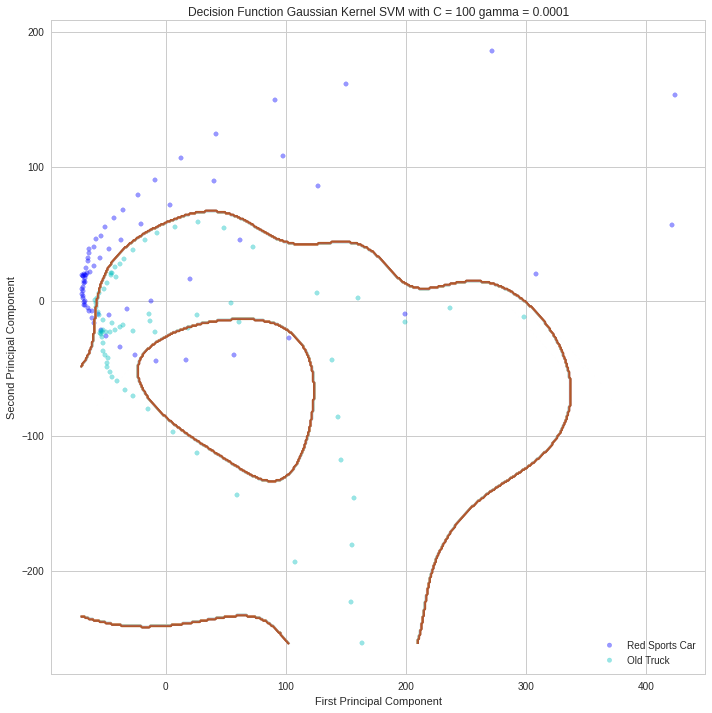

In [105]:
# -*- coding: utf-8 -*-
import numpy as np
import Image
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from itertools import product
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from timeit import default_timer as timer
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from cvxopt import matrix, solvers
from cvxopt.solvers import qp


#### DATA PREPROCESSING #####

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    #img_data3 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car3/obj15__'+str(k)+'.png'))
    if k==0:
        im1 = img_data1
        im2 = img_data2
        #im3 = img_data3
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    #x3 = img_data3.ravel()
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
    #X.append(x3)
    #Y.append(2)  
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)
##X = np.array([[0,0],[1,1],[2,2]])
##y = np.array([1,-1,1])

def dual_svm(X,y):
    pairwise_dists = squareform(pdist(X, 'sqeuclidean'))
    accuracies = []
    times = []
    #param_C = np.logspace(0, 3, 4)
    #param_gamma = np.logspace(-7, -4, 4)
    param_C = [100]
    param_gamma = [0.0001]
    name = raw_input('kernel type (gaussian or linear) ? : ')
    #kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
    
    if name == 'gaussian':
        for tupla in itertools.product(param_C,param_gamma):
            #acc = []
            C = tupla[0]
            gamma = tupla[1]
            #for train_index, test_index in kf1:
                #X_train, X_test = X[train_index], X[test_index]
                #y_train, y_test = y[train_index], y[test_index]
            
            n_s = len(X)
            n_f = len(X[0])
            Q = np.zeros((n_s,n_s))
                
            K = gaussian_kernel(X,gamma)
            for i in range(len(Q)):
                for j in range(len(Q[0])):
                    Q[i,j] = np.inner(y[i],y[j])*K[i,j]
        
            p = -np.ones((n_s,1))
                
            b = np.array([[0.0]])
                
            A = y[np.newaxis]
            A = np.array(A,dtype=float)
                
            G1 = np.eye(n_s)
            G2 = -np.eye(n_s)
            G = np.vstack((G1,G2))
                
            h = np.zeros((2*n_s,1))
                
            h[:n_s] = C
                
            Q = matrix(Q)
            h = matrix(h)
            p = matrix(p)
            G = matrix(G)
            A = matrix(A)
            b = matrix(b)
            solvers.options['show_progress'] = False
            start = timer()
            sol=solvers.qp(Q,p,G,h,A,b)
            end = timer()
            time = end - start
            times.append(time)
            alfa = list(sol['x'])

            spv_indices = [i for i in range(n_s) if alfa[i] > 0.001]
            nospv_indices = [i for i in range(n_s) if alfa[i] < C]
            S = len(spv_indices)
            mIndices = [i for i in range(n_s) if 0.001 < alfa[i] < C]
            M = len(mIndices)
            b = sum([y[j] - sum([alfa[i] * y[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)
        plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices)
        return ''
    
def gaussian_kernel(X,gamma):
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    K = sp.exp(pairwise_dists ** 2 *(-gamma))
    return K

def plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111)#(211)
    D = np.column_stack((X,y))
    class1 = D[D[:, 2] == 1]
    class2 = D[D[:, 2] == -1]
    colors = ['b', 'c']
    l  = plt.scatter(class1[:,0], class1[:,1], marker='o', color=colors[0],alpha=0.4)
    a  = plt.scatter(class2[:,0], class2[:,1], marker='o', color=colors[1],alpha=0.4)
    
    ax.legend((l,a),("Red Sports Car", "Old Truck"),loc ='lower right')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title('Decision Function Gaussian Kernel SVM with C = 100 gamma = 0.0001')

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),np.arange(y_min, y_max, 1))
    Z =  np.c_[xx.ravel(), yy.ravel()]
    z = []
    for i in range(len(Z)):
        val=0
        for j in spv_indices:
            u = np.vstack((X[j],Z[i]))
            p = pdist(u, 'sqeuclidean')
            k = sp.exp(p*(-gamma))
            val = val + alfa[j]*y[j]*k
        z.append(np.sign(val+b))
    Z = np.reshape(z,xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    fig.tight_layout()
    sns.set_style("whitegrid")
    plt.show()

print(dual_svm(X,y))



kernel type (gaussian or linear) ? : linear
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).
Terminated (singular KKT matrix).


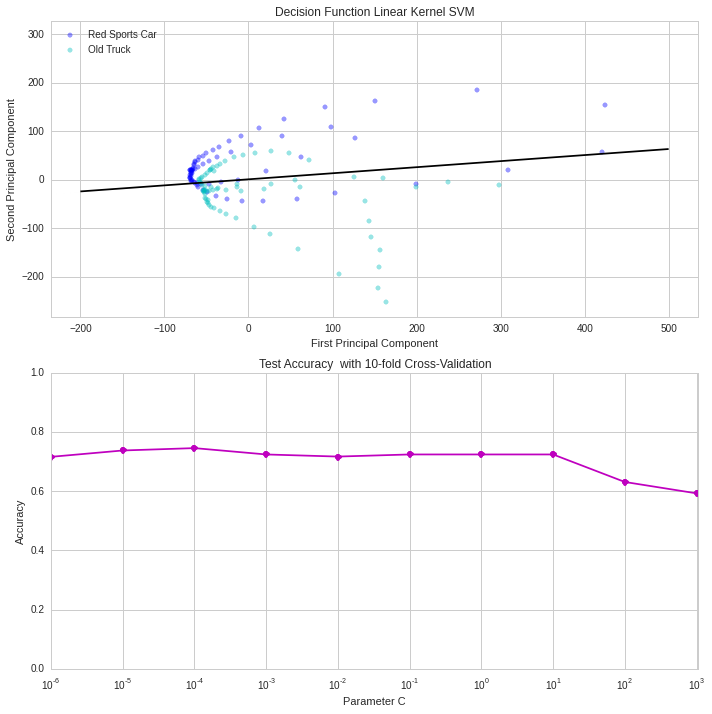

([0.71607142857142869, 0.73750000000000004, 0.7455357142857143, 0.72410714285714284, 0.71696428571428572, 0.72410714285714284, 0.72410714285714284, 0.72410714285714284, 0.63125000000000009, 0.59285714285714286], 'Average Times Optimization Routines 0.0215034675598')


In [94]:
pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    #img_data3 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car3/obj15__'+str(k)+'.png'))
    if k==0:
        im1 = img_data1
        im2 = img_data2
        #im3 = img_data3
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    #x3 = img_data3.ravel()
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
    #X.append(x3)
    #Y.append(2)  
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)
##X = np.array([[0,0],[1,1],[2,2]])
##y = np.array([1,-1,1])

def dual_svm(X,y):
    pairwise_dists = squareform(pdist(X, 'sqeuclidean'))
    accuracies = []
    times = []
    param_C = np.logspace(-6,3,10)
    param_gamma = np.logspace(-7, -4, 4)
    name = raw_input('kernel type (gaussian or linear) ? : ')
    kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
    

    if name == 'linear':
        for C in param_C:
            acc = []
            for train_index, test_index in kf1:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
            
                n_s = len(X_train)
                n_f = len(X_train[0])
                Q = np.zeros((n_s,n_s))

                K = linear_kernel(X_train)
                for i in range(len(Q)):
                    for j in range(len(Q[0])):
                        Q[i,j] = np.inner(y_train[i],y_train[j])*K[i,j]
##           
##                for i in range(len(Q)):
##                    for j in range(len(Q[0])):
##                        Q[i,j] = np.inner(y_train[i],y_train[j])*np.inner(X_train[i], X_train[j])
##                
                p = -np.ones((n_s,1))
                
                b = np.array([[0.0]])
                
                A = y_train[np.newaxis]
                A = np.array(A,dtype=float)
                
                G1 = np.eye(n_s)
                G2 = -np.eye(n_s)
                G = np.vstack((G1,G2))
                
                h = np.zeros((2*n_s,1))
                
                h[:n_s] = C
                
                Q = matrix(Q)
                h = matrix(h)
                p = matrix(p)
                G = matrix(G)
                A = matrix(A)
                b = matrix(b)
                solvers.options['show_progress'] = False
                #solvers.options['feastol']=1e-2
                start = timer()
                sol=solvers.qp(Q,p,G,h,A,b)
                end = timer()
                time = end - start
                times.append(time)
                alfa = list(sol['x'])

                w = np.sum([alfa[i]*y_train[i]*X_train[i,:] for i in range(n_s)], axis=0)        
                spv_indices = [i for i in range(n_s) if alfa[i] > 0]
                nospv_indices = [i for i in range(n_s) if alfa[i] < C]
                S = len(spv_indices)
                mIndices = [i for i in range(n_s) if 0 < alfa[i] < C]
                M = len(mIndices)
                b = sum([y_train[j] - sum([alfa[i] * y_train[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)
                xsv = np.delete(X,nospv_indices,axis=0)

                y_pred = []
                for i in range(len(X_test)):
                    yp = np.sign(np.inner(w,X_test[i])+b)
                    y_pred.append(yp)
                acc.append(accuracy_score(y_test,y_pred))
            K_f_acc = sum(acc)/len(acc)
            accuracies.append(K_f_acc)
        plot_decision_function_linear(w,b,X,y,accuracies,param_C)
        return accuracies,'Average Times Optimization Routines '+str(sum(times)/len(times))

def gaussian_kernel(X,gamma):
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    K = sp.exp(pairwise_dists ** 2 *(-gamma))
    return K

def linear_kernel(X):
    K = np.zeros((len(X),len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            K[i,j] = np.inner(X[i],X[j])
    return K

def plot_decision_function_linear(w,b,X,y,accuracies,param_C):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(211)
    D = np.column_stack((X,y))
    class1 = D[D[:, 2] == 1]
    class2 = D[D[:, 2] == -1]
    colors = ['b', 'c']
    l  = plt.scatter(class1[:,0], class1[:,1], marker='o', color=colors[0],alpha=0.4)
    a  = plt.scatter(class2[:,0], class2[:,1], marker='o', color=colors[1],alpha=0.4)
    z1 = np.linspace(-200, 500)
    z2 = np.linspace(-200, 300)[:, None]
    ax.contour(z1, z2.ravel(), w[0]*z1 + w[1]*z2 + b, [0],colors = 'k')
    ax.legend((l,a),("Red Sports Car", "Old Truck"),loc ='upper left')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title('Decision Function Linear Kernel SVM')

    ax2 = fig.add_subplot(212)
    ax2.set_xticks(param_C,minor=True)                                                       
    ax2.set_xticks(accuracies, minor=False)                                           
    ax2.set_xscale('log', nonposy='clip')
    ax2.set_autoscaley_on(False)
    ax2.set_autoscalex_on(True)
    ax2.plot(param_C,accuracies,color='m', label='Accuracy Test Set',marker = 'o')
    ax2.margins(0.05)
    ax2.set_xlabel('Parameter C')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy  with 10-fold Cross-Validation')
    fig.tight_layout()
    sns.set_style("whitegrid")
    plt.show()


 
print(dual_svm(X,y))



Above we can see the results with linear kernel, and the accuracy is almost the same like the performance of the primal SVM (on the toy dataset without resampling methods the result is the same). 
Note : for high values of C the Hessian matrix become singular (infact the performance decrease) even if increase the tollelance for the feasibility condition.

The SVM-light algorithm can handle high dimensional datasets since doesn't require to keep in memory the Hessian matrix. We fix the parameters C and gamma respectively to 100 and 0.0001 but we change the number of the working set and evaluate the accuracy: 

In [2]:
from __future__ import division
import operator
import numpy as np
import Image
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from functools import reduce
import itertools
from itertools import product
from timeit import default_timer as timer
from scipy.spatial.distance import pdist, squareform
from sklearn import preprocessing 
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from cvxopt import matrix, solvers
from cvxopt.solvers import qp

#### DATA PREPROCESSING #####

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    
    if k==0:
        im1 = img_data1
        im2 = img_data2
        
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
     
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)

def SVM_light_CV(X,y,Wset):
    name = raw_input('kernel type (gaussian or linear) ? : ')
    kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
    #param_C = np.logspace(-2, 2, 5)
    #param_gamma = np.logspace(-2, -2, 5)
    times = []
    param_C = [100]
    accuracies = []
    param_gamma = [0.0001]

    if name == 'gaussian':

        for tupla in itertools.product(param_C,param_gamma,Wset):
            acc = []
            C = tupla[0]
            gamma = tupla[1]
            q = tupla[2]
        
            for train_index, test_index in kf1:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                n_s = len(X_train)
                n_f = len(X_train[0])

                Q = np.zeros((n_s,n_s))
                K = gaussian_kernel(X_train,gamma)
                
                for i in range(len(Q)):
                    for j in range(len(Q[0])):
                        Q[i,j] = np.inner(y[i],y[j])*K[i,j]
                            
                p = -np.ones((n_s,1))

                b = np.array([[0.0]])

                A = y_train[np.newaxis]
                A = np.array(A,dtype=float)

                G1 = np.eye(n_s)
                G2 = -np.eye(n_s)
                G = np.vstack((G1,G2))

                h = np.zeros((2*n_s,1))
                h[:n_s] = C


                ## inizialize alfa all zeros and the numbers of working set q ###

                #q = 2  # number of elements in the working set

                alfa = np.zeros((n_s,1)).flatten()

                ### compute the gradient it is g(alfa) = -1 + Q*alfa and -y*g(alfa)
                one = np.ones((n_s,1)).flatten()
                g_alfa = -1*one + Q.dot(alfa)
                y_g_alfa = -y_train*g_alfa

                iter_ = True
                count = 0
                start = timer()
                while iter_:
                    
                ### now create the two set of indices ###
                    count += 1
                    R = []
                    S = []
                    for index,element in enumerate(alfa):
                        if (element < C and y_train[index] == 1) or (element > 0 and y_train[index] == -1):
                            R.append(index)
                        if (element < C and y_train[index] == -1) or (element > 0 and y_train[index] == 1):
                            S.append(index)

                    ## choosing the q/2 max elements from R and min elements from S ###
                    
                    m_alfa = np.take(y_g_alfa,R)
                    M_alfa = np.take(y_g_alfa,S)

                    # first dict with key the index of R and values the element of m_alfa

                    dr = {}
                    for key, value in zip(R, m_alfa):
                        dr[key] = value
                    ds = {}
                    for key, value in zip(S, M_alfa):
                        ds[key] = value
                    
                    new_S = list(sorted(ds.iteritems(), key=operator.itemgetter(1), reverse=False)[:q//2])
                    new_R = list(sorted(dr.iteritems(), key=operator.itemgetter(1), reverse=True)[:q//2])
                    
                    W1_index = [i[0] for i in new_R ]
                    W1_value = [i[1] for i in new_R ]
                    W2_index = [i[0] for i in new_S ]
                    W2_value = [i[1] for i in new_S ]

                    W = np.concatenate((W1_index,W2_index),axis=0)
                    #W = np.sort(W)
                    
                    Wn = list((set(R).union(set(S))) - set(W)) ### index non-basis variables
                    #Wn = np.sort(Wn)

                    ## create the optimization problem ##

                    alfa_n = np.take(alfa,Wn) # taking the non basis element of alfa

                    Qb = Q[:,W][W,:]      # main matrix indices of working set

                    Qn = Q[W,:][:,Wn]     # matrix element for the row of the working set 

                    alfa_n = np.transpose(alfa_n)
                    p =  - np.ones(q) + np.inner(Qn,alfa_n)

                    y_b  = np.take(y_train,W) # taking the basis element of y (sarebbe matrice vincoli uguaglianza A)
                    y_b = y_b[np.newaxis]
                    y_b = np.array(y_b,dtype=float)

                    y_n = np.take(y_train,Wn).transpose()  # taking the outer basis element of y 
                    b = -np.dot(alfa_n,y_n)   # matrice termini noti vincoli di uguaglianza

                    G1 = np.eye(q)     
                    G2 = -np.eye(q)
                    G = np.vstack((G1,G2))   # matrix of the inequality

                    h = np.zeros((2*q,1))  
                    h[:q] = C             # constant matrix inequality

                    Qb = matrix(Qb)
                    h = matrix(h)
                    p = matrix(p)
                    G = matrix(G)
                    y_b = matrix(y_b)
                    b = matrix(b)
                    solvers.options['show_progress'] = False
                    #solvers.options['abstol']= 1e-10
                    #solvers.options['reltol']= 1e-10
                    #solvers.options['refinement']=1
                    sol=solvers.qp(Qb,p,G,h,y_b,b)

                    #print sol['x'] # reshaping the solution in one dimensional array

                    sol = np.asarray(sol['x'])
                    sol = sol.flatten()

                    # now we update the gradient and th new alfa #
                   
                    alfa_new = np.copy(alfa)
                    
                    np.put(alfa_new,W,sol)
                    #print alfa,alfa_new 
                    for workingindex in W:
                        g_alfa = g_alfa + Q[:,workingindex]*(alfa_new[workingindex] - alfa[workingindex])
                    y_g_alfa = -y_train*g_alfa
                    #print y_g_alfa
                    alfa = alfa_new
                    
                    
                    if (W1_value[0] <=  W2_value[0] + 0.001) or ( count==10000 ):
                        iter_ = False
                end = timer()
                time = end-start
                times.append(time)
                #print alfa
                spv_indices = [i for i in range(n_s) if alfa[i] > 0.00001]
                nospv_indices = [i for i in range(n_s) if alfa[i] < C]
                S = len(spv_indices)
                mIndices = [i for i in range(n_s) if 0.00001 < alfa[i] < C]
                M = len(mIndices)
                b = sum([y_train[j] - sum([alfa[i] * y_train[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)

                y_pred = []
                for i in range(len(X_test)):
                    val = 0
                    for j in spv_indices:
                        u = np.vstack((X_train[j],X_test[i]))
                        p = pdist(u, 'sqeuclidean')
                        k = sp.exp(p*(-gamma))
                        val = val + alfa[j]*y_train[j]*k
                    val = val + b
                    yp = np.sign(val)
                    if yp==0:
                        yp = 1
                    y_pred.append(yp)
                acc.append(accuracy_score(y_test,y_pred))
            K_f_acc = sum(acc)/len(acc)
            accuracies.append(tupla)
            accuracies.append(K_f_acc)
            accuracies.append('# working set '+str(q))
        #plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices)
        return accuracies,'Average Times Optimization Routines '+str(sum(times)/len(times))

    if name == 'linear':

        for C in param_C:
            acc = []
            for train_index, test_index in kf1:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]


                n_s = len(X_train)
                n_f = len(X_train[0])

                Q = np.zeros((n_s,n_s))
                K = linear_kernel(X_train)
                
                for i in range(len(Q)):
                    for j in range(len(Q[0])):
                        Q[i,j] = np.inner(y[i],y[j])*K[i,j]
                            
                p = -np.ones((n_s,1))

                b = np.array([[0.0]])

                A = y_train[np.newaxis]
                A = np.array(A,dtype=float)

                G1 = np.eye(n_s)
                G2 = -np.eye(n_s)
                G = np.vstack((G1,G2))

                h = np.zeros((2*n_s,1))
                h[:n_s] = C


                ## inizialize alfa all zeros and the numbers of working set q ###

                q = 2  # number of elements in the working set

                alfa = np.zeros((n_s,1)).flatten()

                ### compute the gradient it is g(alfa) = -1 + Q*alfa and -y*g(alfa)
                one = np.ones((n_s,1)).flatten()
                g_alfa = -1*one + Q.dot(alfa)
                y_g_alfa = -y_train*g_alfa

                iter_ = True
                count = 0
                start = timer()
                while iter_: 
                ### now create the two set of indices ###
                    count += 1
                    R = []
                    S = []
                    for index,element in enumerate(alfa):
                        if (element < C and y_train[index] == 1) or (element > 0 and y_train[index] == -1):
                            R.append(index)
                        if (element < C and y_train[index] == -1) or (element > 0 and y_train[index] == 1):
                            S.append(index)

                    ## choosing the q/2 max elements from R and min elements from S ###
                    
                    m_alfa = np.take(y_g_alfa,R)
                    M_alfa = np.take(y_g_alfa,S)

                    # first dict with key the index of R and values the element of m_alfa

                    dr = {}
                    for key, value in zip(R, m_alfa):
                        dr[key] = value
                    ds = {}
                    for key, value in zip(S, M_alfa):
                        ds[key] = value
                    
                    new_S = list(sorted(ds.iteritems(), key=operator.itemgetter(1), reverse=False)[:q//2])
                    new_R = list(sorted(dr.iteritems(), key=operator.itemgetter(1), reverse=True)[:q//2])
                    
                    W1_index = [i[0] for i in new_R ]
                    W1_value = [i[1] for i in new_R ]
                    W2_index = [i[0] for i in new_S ]
                    W2_value = [i[1] for i in new_S ]

                    W = np.concatenate((W1_index,W2_index),axis=0)
                    #W = np.sort(W)
                    
                    Wn = list((set(R).union(set(S))) - set(W)) ### index non-basis variables
                    #Wn = np.sort(Wn)

                    ## create the optimization problem ##

                    alfa_n = np.take(alfa,Wn) # taking the non basis element of alfa

                    Qb = Q[:,W][W,:]      # main matrix indices of working set

                    Qn = Q[W,:][:,Wn]     # matrix element for the row of the working set 

                    alfa_n = np.transpose(alfa_n)
                    p =  - np.ones(q) + np.inner(Qn,alfa_n)

                    y_b  = np.take(y_train,W) # taking the basis element of y (sarebbe matrice vincoli uguaglianza A)
                    y_b = y_b[np.newaxis]
                    y_b = np.array(y_b,dtype=float)

                    y_n = np.take(y_train,Wn).transpose()  # taking the outer basis element of y 
                    b = -np.dot(alfa_n,y_n)   # matrice termini noti vincoli di uguaglianza

                    G1 = np.eye(q)     
                    G2 = -np.eye(q)
                    G = np.vstack((G1,G2))   # matrix of the inequality

                    h = np.zeros((2*q,1))  
                    h[:q] = C             # constant matrix inequality

                    Qb = matrix(Qb)
                    h = matrix(h)
                    p = matrix(p)
                    G = matrix(G)
                    y_b = matrix(y_b)
                    b = matrix(b)
                    solvers.options['show_progress'] = False
                    solvers.options['abstol']= 1e-10
                    solvers.options['reltol']= 1e-10
                    solvers.options['refinement']=1
                    sol=solvers.qp(Qb,p,G,h,y_b,b)

                    #print sol['x'] # reshaping the solution in one dimensional array

                    sol = np.asarray(sol['x'])
                    sol = sol.flatten()

                    # now we update the gradient and th new alfa #
                   
                    alfa_new = np.copy(alfa)
                    
                    np.put(alfa_new,W,sol)
                    #print alfa,alfa_new 
                    for workingindex in W:
                        g_alfa = g_alfa + Q[:,workingindex]*(alfa_new[workingindex] - alfa[workingindex])
                    y_g_alfa = -y_train*g_alfa
                    #print y_g_alfa
                    alfa = alfa_new
                    end = timer()
                
                    
                    
                    if (W1_value[0] <=  W2_value[0] + 1.3) or ( count==100 ):
                        iter_ = False
                w = np.sum([alfa[i]*y_train[i]*X_train[i,:] for i in range(n_s)], axis=0)        
                spv_indices = [i for i in range(n_s) if alfa[i] > 0.0001]
                nospv_indices = [i for i in range(n_s) if alfa[i] < C-1]
                S = len(spv_indices)
                mIndices = [i for i in range(n_s) if 0 < alfa[i] < C]
                M = len(mIndices)
                b = sum([y_train[j] - sum([alfa[i] * y_train[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)
                xsv = np.delete(X,nospv_indices,axis=0)
                y_pred = []
                for i in range(len(X_train)):
                    yp = np.sign(np.inner(w,X_train[i])+b)
                    if yp == 0 :
                        yp = 1
                    y_pred.append(yp)
                print y_pred,y_train
                acc.append(accuracy_score(y_train,y_pred))
            K_f_acc = sum(acc)/len(acc)
            accuracies.append(K_f_acc)
        plot_decision_function_linear(w,b,X,y,accuracies,param_C)
        print accuracies
                

def gaussian_kernel(X,gamma):
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    K = sp.exp(pairwise_dists ** 2 *(-gamma))
    return K

def linear_kernel(X):
    K = np.zeros((len(X),len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            K[i,j] = np.inner(X[i],X[j])
    return K

def plot_decision_function_linear(w,b,X,y,accuracies,param_C):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    D = np.column_stack((X,y))
    class1 = D[D[:, 2] == 1]
    class2 = D[D[:, 2] == -1]
    colors = ['b', 'c']
    l  = plt.scatter(class1[:,0], class1[:,1], marker='o', color=colors[0],alpha=0.4)
    a  = plt.scatter(class2[:,0], class2[:,1], marker='o', color=colors[1],alpha=0.4)
    z1 = np.linspace(-200, 500)
    z2 = np.linspace(-200, 300)[:, None]
    ax.contour(z1, z2.ravel(), w[0]*z1 + w[1]*z2 + b, [0],colors = 'k')
    ax.legend((l,a),("Red Sports Car", "Fire Truck"),loc ='upper left')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title('Decision Function Primal SVM')

    ax2 = fig.add_subplot(212)
    ax2.set_xticks(param_C,minor=True)                                                       
    ax2.set_xticks(accuracies, minor=False)                                           
    ax2.set_xscale('log', nonposy='clip')
    ax2.set_autoscaley_on(False)
    ax2.set_autoscalex_on(True)
    ax2.plot(param_C,accuracies,color='m', label='Accuracy Test Set',marker = 'o')
    ax2.margins(0.05)
    ax2.set_xlabel('Parameter C')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy  with 10-fold Cross-Validation')
    fig.tight_layout()
    sns.set_style("white")
    plt.show()

def plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    D = np.column_stack((X,y))
    class1 = D[D[:, 2] == 1]
    class2 = D[D[:, 2] == -1]
    colors = ['b', 'c']
    l  = plt.scatter(class1[:,0], class1[:,1], marker='o', color=colors[0],alpha=0.4)
    a  = plt.scatter(class2[:,0], class2[:,1], marker='o', color=colors[1],alpha=0.4)
    
    ax.legend((l,a),("Red Sports Car", "Old Truck"),loc ='upper right')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title('Decision Function Gaussian Kernel SVM with C = 100 gamma = 0.0001')

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),np.arange(y_min, y_max, 1))
    Z =  np.c_[xx.ravel(), yy.ravel()]
    z = []
    print Z,np.shape(Z)
    for i in range(len(Z)):
        val=0
        for j in spv_indices:
            u = np.vstack((X[j],Z[i]))
            p = pdist(u, 'sqeuclidean')
            k = sp.exp(p*(-gamma))
            val = val + alfa[j]*y[j]*k
        z.append(val+b)
    Z = np.reshape(z,xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.show()

print(SVM_light_CV(X,y,[2]))


kernel type (gaussian or linear) ? : gaussian
([(100, 0.0001, 2), 0.69285714285714284, '# working set 2'], 'Average Times Optimization Routines 24.5604778051')


The best working set is 8, so we fix this and plot the non linear decision function : 

kernel type (gaussian or linear) ? : gaussian


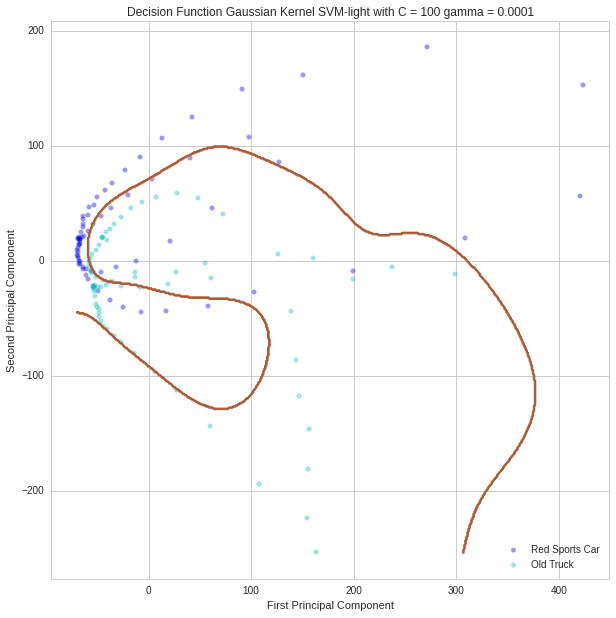

In [110]:
from __future__ import division
import operator
import numpy as np
import Image
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from functools import reduce
import itertools
from itertools import product
from timeit import default_timer as timer
from scipy.spatial.distance import pdist, squareform
from sklearn import preprocessing 
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from cvxopt import matrix, solvers
from cvxopt.solvers import qp

#### DATA PREPROCESSING #####

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    
    if k==0:
        im1 = img_data1
        im2 = img_data2
        
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
     
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)

def SVM_light_CV(X,y,q):
    name = raw_input('kernel type (gaussian or linear) ? : ')
    kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
    times = []
    param_C = [100]
    accuracies = []
    param_gamma = [0.0001]

    if name == 'gaussian':

        for tupla in itertools.product(param_C,param_gamma):
            acc = []
            C = tupla[0]
            gamma = tupla[1]
            #for train_index, test_index in kf1:
                #X_train, X_test = X[train_index], X[test_index]
                #y_train, y_test = y[train_index], y[test_index]
            n_s = len(X)
            n_f = len(X[0])

            Q = np.zeros((n_s,n_s))
            K = gaussian_kernel(X,gamma)
                
            for i in range(len(Q)):
                for j in range(len(Q[0])):
                    Q[i,j] = np.inner(y[i],y[j])*K[i,j]
                            
            p = -np.ones((n_s,1))

            b = np.array([[0.0]])

            A = y[np.newaxis]
            A = np.array(A,dtype=float)

            G1 = np.eye(n_s)
            G2 = -np.eye(n_s)
            G = np.vstack((G1,G2))

            h = np.zeros((2*n_s,1))
            h[:n_s] = C


                ## inizialize alfa all zeros and the numbers of working set q ###

                #q = 2  # number of elements in the working set

            alfa = np.zeros((n_s,1)).flatten()

                ### compute the gradient it is g(alfa) = -1 + Q*alfa and -y*g(alfa)
            one = np.ones((n_s,1)).flatten()
            g_alfa = -1*one + Q.dot(alfa)
            y_g_alfa = -y*g_alfa

            iter_ = True
            count = 0
            start = timer()
            while iter_:
                    
                ### now create the two set of indices ###
                count += 1
                R = []
                S = []
                for index,element in enumerate(alfa):
                    if (element < C and y[index] == 1) or (element > 0 and y[index] == -1):
                            R.append(index)
                    if (element < C and y[index] == -1) or (element > 0 and y[index] == 1):
                            S.append(index)

                    ## choosing the q/2 max elements from R and min elements from S ###
                    
                m_alfa = np.take(y_g_alfa,R)
                M_alfa = np.take(y_g_alfa,S)

                    # first dict with key the index of R and values the element of m_alfa

                dr = {}
                for key, value in zip(R, m_alfa):
                    dr[key] = value
                ds = {}
                for key, value in zip(S, M_alfa):
                    ds[key] = value
                    
                new_S = list(sorted(ds.iteritems(), key=operator.itemgetter(1), reverse=False)[:q//2])
                new_R = list(sorted(dr.iteritems(), key=operator.itemgetter(1), reverse=True)[:q//2])
                    
                W1_index = [i[0] for i in new_R ]
                W1_value = [i[1] for i in new_R ]
                W2_index = [i[0] for i in new_S ]
                W2_value = [i[1] for i in new_S ]

                W = np.concatenate((W1_index,W2_index),axis=0)
                    #W = np.sort(W)
                    
                Wn = list((set(R).union(set(S))) - set(W)) ### index non-basis variables
                    #Wn = np.sort(Wn)

                    ## create the optimization problem ##

                alfa_n = np.take(alfa,Wn) # taking the non basis element of alfa

                Qb = Q[:,W][W,:]      # main matrix indices of working set

                Qn = Q[W,:][:,Wn]     # matrix element for the row of the working set 

                alfa_n = np.transpose(alfa_n)
                p =  - np.ones(q) + np.inner(Qn,alfa_n)

                y_b  = np.take(y,W) # taking the basis element of y (sarebbe matrice vincoli uguaglianza A)
                y_b = y_b[np.newaxis]
                y_b = np.array(y_b,dtype=float)

                y_n = np.take(y,Wn).transpose()  # taking the outer basis element of y 
                b = -np.dot(alfa_n,y_n)   # matrice termini noti vincoli di uguaglianza

                G1 = np.eye(q)     
                G2 = -np.eye(q)
                G = np.vstack((G1,G2))   # matrix of the inequality

                h = np.zeros((2*q,1))  
                h[:q] = C             # constant matrix inequality

                Qb = matrix(Qb)
                h = matrix(h)
                p = matrix(p)
                G = matrix(G)
                y_b = matrix(y_b)
                b = matrix(b)
                solvers.options['show_progress'] = False
                    #solvers.options['abstol']= 1e-10
                    #solvers.options['reltol']= 1e-10
                    #solvers.options['refinement']=1
                sol=solvers.qp(Qb,p,G,h,y_b,b)

                    #print sol['x'] # reshaping the solution in one dimensional array

                sol = np.asarray(sol['x'])
                sol = sol.flatten()

                    # now we update the gradient and th new alfa #
                   
                alfa_new = np.copy(alfa)
                    
                np.put(alfa_new,W,sol)
                    #print alfa,alfa_new 
                for workingindex in W:
                    g_alfa = g_alfa + Q[:,workingindex]*(alfa_new[workingindex] - alfa[workingindex])
                y_g_alfa = -y*g_alfa
                    #print y_g_alfa
                alfa = alfa_new
                    
                    
                if (W1_value[0] <=  W2_value[0] + 0.001) or ( count==10000 ):
                    iter_ = False
            end = timer()
            time = end-start
            times.append(time)
                #print alfa
            spv_indices = [i for i in range(n_s) if alfa[i] > 0.00001]
            nospv_indices = [i for i in range(n_s) if alfa[i] < C]
            S = len(spv_indices)
            mIndices = [i for i in range(n_s) if 0.00001 < alfa[i] < C]
            M = len(mIndices)
            b = sum([y[j] - sum([alfa[i] * y[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)
        plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices)
        return ''
            
    
def gaussian_kernel(X,gamma):
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    K = sp.exp(pairwise_dists ** 2 *(-gamma))
    return K

def plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111)
    D = np.column_stack((X,y))
    class1 = D[D[:, 2] == 1]
    class2 = D[D[:, 2] == -1]
    colors = ['b', 'c']
    l  = plt.scatter(class1[:,0], class1[:,1], marker='o', color=colors[0],alpha=0.4)
    a  = plt.scatter(class2[:,0], class2[:,1], marker='o', color=colors[1],alpha=0.4)
    
    ax.legend((l,a),("Red Sports Car", "Old Truck"),loc ='lower right')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title('Decision Function Gaussian Kernel SVM-light with C = 100 gamma = 0.0001')

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),np.arange(y_min, y_max, 1))
    Z =  np.c_[xx.ravel(), yy.ravel()]
    z = []
    for i in range(len(Z)):
        val=0
        for j in spv_indices:
            u = np.vstack((X[j],Z[i]))
            p = pdist(u, 'sqeuclidean')
            k = sp.exp(p*(-gamma))
            val = val + alfa[j]*y[j]*k
        z.append(np.sign(val+b))
    Z = np.reshape(z,xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)
    plt.show()

print(SVM_light_CV(X,y,8))


Below the result from the implementation of the Sequential Minimization Optimization algorithm with the same choice of the parameters : 

In [98]:
# -*- coding: utf-8 -*-
from __future__ import division
import operator
import numpy as np
import Image
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from functools import reduce
import itertools
from itertools import product
from timeit import default_timer as timer
from scipy.spatial.distance import pdist, squareform
from sklearn import preprocessing 
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from cvxopt import matrix, solvers
from cvxopt.solvers import qp

#### DATA PREPROCESSING #####

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    
    if k==0:
        im1 = img_data1
        im2 = img_data2
        
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
     
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)

def SMO_CV(X,y,q):
    name = raw_input('kernel type (gaussian or linear) ? : ')
    kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
    #param_C = np.logspace(-5, 5, 11)
    #param_gamma = np.logspace(-5, -5, 11)
    param_C = [100]
    accuracies = []
    param_gamma = [0.0001]
    times = []
    if name == 'gaussian':

        for tupla in itertools.product(param_C,param_gamma):
            acc = []
            C = tupla[0]
            gamma = tupla[1]
            for train_index, test_index in kf1:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                n_s = len(X_train)
                n_f = len(X_train[0])

                Q = np.zeros((n_s,n_s))
                K = gaussian_kernel(X_train,gamma)
                
                for i in range(len(Q)):
                    for j in range(len(Q[0])):
                        Q[i,j] = np.inner(y[i],y[j])*K[i,j]
                            
                p = -np.ones((n_s,1))

                b = np.array([[0.0]])

                A = y_train[np.newaxis]
                A = np.array(A,dtype=float)

                G1 = np.eye(n_s)
                G2 = -np.eye(n_s)
                G = np.vstack((G1,G2))

                h = np.zeros((2*n_s,1))
                h[:n_s] = C


                ## inizialize alfa all zeros and the numbers of working set q ###

                #q = 2  # number of elements in the working set

                alfa = np.zeros((n_s,1)).flatten()

                ### compute the gradient it is g(alfa) = -1 + Q*alfa and -y*g(alfa)
                one = np.ones((n_s,1)).flatten()
                g_alfa = -1*one + Q.dot(alfa)
                y_g_alfa = -y_train*g_alfa

                iter_ = True
                count = 0
                start = timer()
                while iter_: 
                ### now create the two set of indices ###
                    count += 1
                    R = []
                    S = []
                    for index,element in enumerate(alfa):
                        if (element < C and y_train[index] == 1) or (element > 0 and y_train[index] == -1):
                            R.append(index)
                        if (element < C and y_train[index] == -1) or (element > 0 and y_train[index] == 1):
                            S.append(index)

                    ## choosing the q/2 max elements from R and min elements from S ###
                    
                    m_alfa = np.take(y_g_alfa,R)
                    M_alfa = np.take(y_g_alfa,S)

                    # first dict with key the index of R and values the element of m_alfa

                    dr = {}
                    for key, value in zip(R, m_alfa):
                        dr[key] = value
                    ds = {}
                    for key, value in zip(S, M_alfa):
                        ds[key] = value
                    
                    new_S = list(sorted(ds.iteritems(), key=operator.itemgetter(1), reverse=False)[:q//2])
                    new_R = list(sorted(dr.iteritems(), key=operator.itemgetter(1), reverse=True)[:q//2])
                    
                    W1_index = [i[0] for i in new_R ]
                    W1_value = [i[1] for i in new_R ]
                    W2_index = [i[0] for i in new_S ]
                    W2_value = [i[1] for i in new_S ]

                    W = np.concatenate((W1_index,W2_index),axis=0)
                    #W = np.sort(W)
                    
                    Wn = list((set(R).union(set(S))) - set(W)) ### index non-basis variables
                    #Wn = np.sort(Wn)

                    ## create the optimization problem ##

                    

                    alfa_n = np.take(alfa,Wn) # taking the non basis element of alfa
                    d_ = np.take(y_train,W)    # computing d taking the values of y n the working set
                    d_[1] *= -1 # this is -1/y2,
                    
                    y_n = np.take(y_train,Wn).transpose()   # compute the constant b at the equality
                    b = -np.dot(alfa_n,y_n)
                    alfa_2 = C                  #taking tha ammissible point alfa_2
                    y1 = np.take(y_train,W[0])      # take y value of alfa_1
                    y2 = np.take(y_train,W[1])
                    alfa_1 = (b - alfa_2*y2)/y1              
                    alfa_ = np.array([alfa_1,alfa_2])  #alfa_ ammissible point
                    #print b,alfa_1                              
                    
                    Qb = Q[:,W][W,:]                      # now construct the gradient in alfa_

                    Qn = Q[W,:][:,Wn]                     # we construct the vector of the first grade derivative
                    alfa_n = np.transpose(alfa_n)
                    p =   -np.ones(q) + np.inner(Qn,alfa_n)
                    g_alfa_ = p + np.dot(Qb,alfa_) # the gradient is p + alfa_*Qb
                    
                    if d_[0]>0 and d_[1]>0:                  # the conditions of beta_
                        beta_ = np.amin(np.array([C-alfa_1,C-alfa_2]))
                    if d_[0]<0 and d_[1]<0:
                        beta_ = np.amin(np.array([alfa_1,alfa_2]))
                    if d_[0]>0 and d_[1]<0:
                        beta_ = np.amin(np.array([C-alfa_1,alfa_2]))
                    if d_[0]<0 and d_[1]>0:
                        beta_ = np.amin(np.array([alfa_1,C-alfa_2]))
                    
                    #if np.inner(g_alfa_,d_)==0:
                        #alfa_ott = alfa_
                    if np.inner(g_alfa_,d_)<0:
                        d = -d_
                    if np.inner(g_alfa_,d_)>0:
                        d = d_
                    if np.inner(g_alfa_,d_)==0:
                        alfa_ott = alfa_
                        d = 1
                    if beta_==0:
                        alfa_ott = alfa_
                    
                    Qdot = np.dot(d,Qb)

                    if np.inner(d,Qdot) == 0:
                        alfa_ott = alfa_ + beta_*d 
                    if np.inner(d,Qdot) > 0:
                        b_nv = -np.inner(g_alfa_,d)/np.inner(d,Qdot)
                        beta = np.amin(np.array([beta_,b_nv]))
                        alfa_ott = alfa_ + beta*d
                        # now we update the gradient and th new alfa #
                   
                    alfa_new = np.copy(alfa)
                    
                    np.put(alfa_new,W,alfa_ott)
                    #print alfa,alfa_new 
                    for workingindex in W:
                        g_alfa = g_alfa + Q[:,workingindex]*(alfa_new[workingindex] - alfa[workingindex])
                    y_g_alfa = -y_train*g_alfa
                    #print y_g_alfa
                    alfa = alfa_new
                    
                    
                    if (W1_value[0] <=  W2_value[0] + 0.001) or ( count==10000 ):
                        iter_ = False
                end = timer()
                time = end-start
                times.append(time)
                #print alfa
                spv_indices = [i for i in range(n_s) if alfa[i] > 0]
                nospv_indices = [i for i in range(n_s) if alfa[i] < C]
                S = len(spv_indices)
                mIndices = [i for i in range(n_s) if 0 < alfa[i] < C]
                M = len(mIndices)
                b = sum([y_train[j] - sum([alfa[i] * y_train[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)

                y_pred = []
                for i in range(len(X_test)):
                    val = 0
                    for j in spv_indices:
                        u = np.vstack((X_train[j],X_test[i]))
                        p = pdist(u, 'sqeuclidean')
                        k = sp.exp(p*(-gamma))
                        val = val + alfa[j]*y_train[j]*k
                    val = val + b
                    yp = np.sign(val)
                    if yp==0:
                        yp = 1
                    y_pred.append(yp)
                acc.append(accuracy_score(y_test,y_pred))
            K_f_acc = sum(acc)/len(acc)
            accuracies.append(tupla)
            accuracies.append(K_f_acc)
        #plot_decision_function_gaussian(b,X,y,accuracies,param_C,gamma,alfa,spv_indices)
        return accuracies,'Average Times Optimization Routines '+str(sum(times)/len(times))

    if name == 'linear':

        for C in param_C:
            acc = []
            for train_index, test_index in kf1:
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]


                n_s = len(X_train)
                n_f = len(X_train[0])

                Q = np.zeros((n_s,n_s))
                K = linear_kernel(X_train)
                
                for i in range(len(Q)):
                    for j in range(len(Q[0])):
                        Q[i,j] = np.inner(y[i],y[j])*K[i,j]
                            
                p = -np.ones((n_s,1))

                b = np.array([[0.0]])

                A = y_train[np.newaxis]
                A = np.array(A,dtype=float)

                G1 = np.eye(n_s)
                G2 = -np.eye(n_s)
                G = np.vstack((G1,G2))

                h = np.zeros((2*n_s,1))
                h[:n_s] = C


                ## inizialize alfa all zeros and the numbers of working set q ###

                q = 2  # number of elements in the working set

                alfa = np.zeros((n_s,1)).flatten()

                ### compute the gradient it is g(alfa) = -1 + Q*alfa and -y*g(alfa)
                one = np.ones((n_s,1)).flatten()
                g_alfa = -1*one + Q.dot(alfa)
                y_g_alfa = -y_train*g_alfa

                iter_ = True
                count = 0
                while iter_: 
                ### now create the two set of indices ###
                    count += 1
                    R = []
                    S = []
                    for index,element in enumerate(alfa):
                        if (element < C and y_train[index] == 1) or (element > 0 and y_train[index] == -1):
                            R.append(index)
                        if (element < C and y_train[index] == -1) or (element > 0 and y_train[index] == 1):
                            S.append(index)

                    ## choosing the q/2 max elements from R and min elements from S ###
                    
                    m_alfa = np.take(y_g_alfa,R)
                    M_alfa = np.take(y_g_alfa,S)

                    # first dict with key the index of R and values the element of m_alfa

                    dr = {}
                    for key, value in zip(R, m_alfa):
                        dr[key] = value
                    ds = {}
                    for key, value in zip(S, M_alfa):
                        ds[key] = value
                    
                    new_S = list(sorted(ds.iteritems(), key=operator.itemgetter(1), reverse=False)[:q//2])
                    new_R = list(sorted(dr.iteritems(), key=operator.itemgetter(1), reverse=True)[:q//2])
                    
                    W1_index = [i[0] for i in new_R ]
                    W1_value = [i[1] for i in new_R ]
                    W2_index = [i[0] for i in new_S ]
                    W2_value = [i[1] for i in new_S ]

                    W = np.concatenate((W1_index,W2_index),axis=0)
                    #W = np.sort(W)
                    
                    Wn = list((set(R).union(set(S))) - set(W)) ### index non-basis variables
                    #Wn = np.sort(Wn)

                    ## create the optimization problem ##

                    alfa_n = np.take(alfa,Wn) # taking the non basis element of alfa
                    d_ = np.take(y_train,W)    # computing d taking the values of y n the working set
                    d_[1] *= -1 # this is -1/y2,
                    
                    y_n = np.take(y_train,Wn).transpose()   # compute the constant b at the equality
                    b = -np.dot(alfa_n,y_n)
                    alfa_2 = C                  #taking tha ammissible point alfa_2
                    y1 = np.take(y_train,W[0])      # take y value of alfa_1
                    y2 = np.take(y_train,W[1])
                    alfa_1 = (b - alfa_2*y2)/y1              
                    alfa_ = np.array([alfa_1,alfa_2])  #alfa_ ammissible point
                    #print b,alfa_1                              
                    
                    Qb = Q[:,W][W,:]                      # now construct the gradient in alfa_

                    Qn = Q[W,:][:,Wn]                     # we construct the vector of the first grade derivative
                    alfa_n = np.transpose(alfa_n)
                    p =   -np.ones(q) + np.inner(Qn,alfa_n)
                    g_alfa_ = p + np.dot(Qb,alfa_) # the gradient is p + alfa_*Qb
                    
                    if d_[0]>0 and d_[1]>0:                  # the conditions of beta_
                        beta_ = np.amin(np.array([C-alfa_1,C-alfa_2]))
                    if d_[0]<0 and d_[1]<0:
                        beta_ = np.amin(np.array([alfa_1,alfa_2]))
                    if d_[0]>0 and d_[1]<0:
                        beta_ = np.amin(np.array([C-alfa_1,alfa_2]))
                    if d_[0]<0 and d_[1]>0:
                        beta_ = np.amin(np.array([alfa_1,C-alfa_2]))
                    
                    if np.inner(g_alfa_,d_)==0:
                        alfa_ott = alfa_
                    if np.inner(g_alfa_,d_)<0:
                        d = -d_
                    if np.inner(g_alfa_,d_)>0:
                        d = d_

                    if beta_==0:
                        alfa_ott = alfa_
                    
                    Qdot = np.dot(d,Qb)

                    if np.inner(d,Qdot) == 0:
                        alfa_ott = alfa_ + beta_*d 
                    if np.inner(d,Qdot) > 0:
                        b_nv = -np.inner(g_alfa_,d)/np.inner(d,Qdot)
                        beta = np.amin(np.array([beta_,b_nv]))
                        alfa_ott = alfa_ + beta*d
                        # now we update the gradient and th new alfa #
                   
                    alfa_new = np.copy(alfa)
                    
                    np.put(alfa_new,W,alfa_ott)
 
                    for workingindex in W:
                        g_alfa = g_alfa + Q[:,workingindex]*(alfa_new[workingindex] - alfa[workingindex])
                    y_g_alfa = -y_train*g_alfa
                    alfa = alfa_new
                    if (W1_value[0] <=  W2_value[0] + 0.001) or ( count==10000 ):
                        iter_ = False

                w = np.sum([alfa[i]*y_train[i]*X_train[i,:] for i in range(n_s)], axis=0)        
                spv_indices = [i for i in range(n_s) if alfa[i] > 0.0001]
                nospv_indices = [i for i in range(n_s) if alfa[i] < C-1]
                S = len(spv_indices)
                mIndices = [i for i in range(n_s) if 0 < alfa[i] < C]
                M = len(mIndices)
                b = sum([y_train[j] - sum([alfa[i] * y_train[i] * K[j,i] for i in spv_indices]) for j in mIndices])/float(M)
                xsv = np.delete(X,nospv_indices,axis=0)
                y_pred = []
                for i in range(len(X_train)):
                    yp = np.sign(np.inner(w,X_train[i])+b)
                    if yp == 0 :
                        yp = 1
                    y_pred.append(yp)
                
                acc.append(accuracy_score(y_train,y_pred))
            K_f_acc = sum(acc)/len(acc)
            accuracies.append(K_f_acc)
        plot_decision_function_linear(w,b,X,y,accuracies,param_C)
        return accuracies
                

def gaussian_kernel(X,gamma):
    pairwise_dists = squareform(pdist(X, 'euclidean'))
    K = sp.exp(pairwise_dists ** 2 *(-gamma))
    return K

def linear_kernel(X):
    K = np.zeros((len(X),len(X)))
    for i in range(len(X)):
        for j in range(len(X)):
            K[i,j] = np.inner(X[i],X[j])
    return K


print(SMO_CV(X,y,2))


kernel type (gaussian or linear) ? : gaussian
([(100, 0.0001), 0.75714285714285701], 'Average Times Optimization Routines 9.98266060352')


Finally we compute a Multi-Class SVM with one-versus-all approach ; now the dataset is composed by the following three classes, the red sports car and :

In [57]:
img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__260.png'))
img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/frog/obj28__260.png'))
img_data3 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/duck/obj74__225.png'))

A frog :

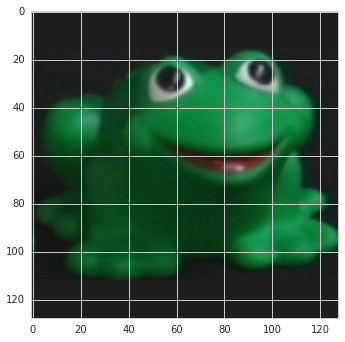

In [59]:
iview = plt.imshow(img_data2)

And a duck :

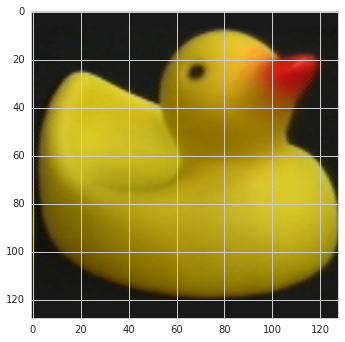

In [60]:
iview = plt.imshow(img_data3)

Below the results : 

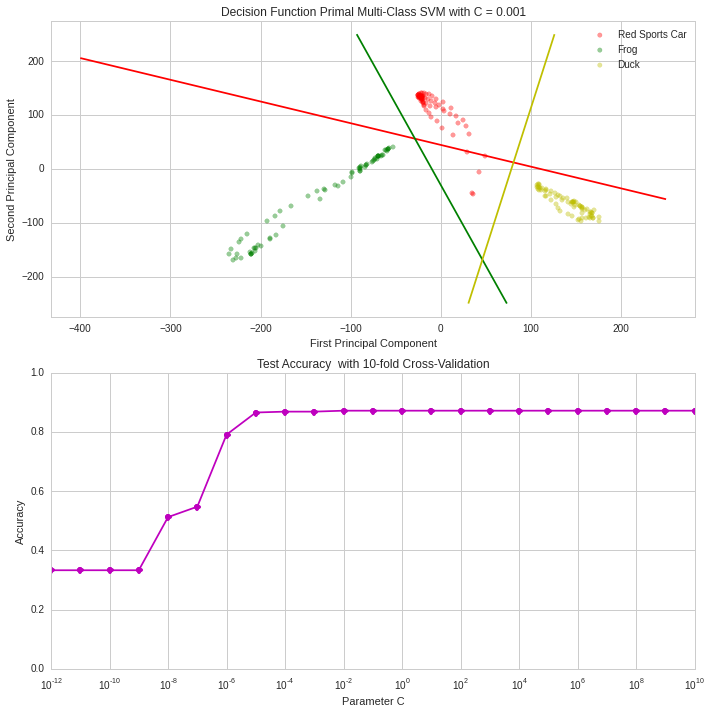

[0.33333333333333331, 0.33333333333333331, 0.33333333333333331, 0.33333333333333331, 0.51269841269841288, 0.54781746031746048, 0.79107142857142876, 0.86567460317460332, 0.86865079365079378, 0.86865079365079378, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695, 0.87182539682539695]


In [201]:
# -*- coding: utf-8 -*-
import numpy as np
import Image
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from scipy.spatial.distance import pdist, squareform
from timeit import default_timer as timer
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from cvxopt import matrix, solvers
from cvxopt.solvers import qp

#### DATA PREPROCESSING #####

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/frog/obj28__'+str(k)+'.png'))
    img_data3 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/duck/obj74__'+str(k)+'.png'))
    if k==0:
        im1 = img_data1
        im2 = img_data2
        im3 = img_data3
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    x3 = img_data3.ravel()
    X.append(x1)
    Y.append(0)  
    X.append(x2)
    Y.append(1)   
    X.append(x3)
    Y.append(2)  
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)
label = np.array([0,1,2])

def primal_svm(X,y,param_C):
    accuracies = []
    kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
    labels = np.array([0,1,2])
    plot_param = []
    for C in param_C:
        acc=[]
        for train_index, test_index in kf1:
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            decisions_f = np.zeros((len(X_test),len(labels)))
            for label in labels:
                yl = np.copy(y_train)
                yl[yl!=label]=-1
                yl[yl==label]=1
              
                n_s = len(X_train)
                n_f = len(X_train[0])
                
                m = np.eye(n_s)
                m = np.dot(-1,m)
                mz = np.zeros((n_s,n_f +1))
                c = np.column_stack((mz,m))
                b = np.ones(n_s)
                y1 = np.dot(-1,yl)
                G1 = np.column_stack((X_train,b))
                m1 = G1*y1[:, np.newaxis] 
                G2 = np.column_stack((m1,m))
                G = np.vstack((G2,c))

                h1 = np.ones(n_s)
                h1 = np.dot(-1,h1)
                h2 = np.zeros(n_s)
                h = np.concatenate((h1,h2))

                Q = np.zeros((n_s+n_f+1,n_s+n_f+1))
                for i in range(n_f):
                    Q[i,i] = 1
                
                p1 = C*np.ones(n_s)
                p2 = np.zeros(n_f+1) 
                p = np.concatenate((p2,p1))
                
                Q = matrix(Q)
                h = matrix(h)
                p = matrix(p)
                G = matrix(G)
                solvers.options['show_progress'] = False
                start = timer()
                sol=solvers.qp(Q,p,G, h)
                end = timer()
                time = end - start
                w = [sol['x'][0],sol['x'][1]]
                b = sol['x'][2]
                y_pred = []
                if C == param_C[9] and len(plot_param)<8 :
                    if C not in plot_param:
                        plot_param.append(C)
                    plot_param.append(w[0])
                    plot_param.append(w[1])
                    plot_param.append(b)
                
                for i in range(len(X_test)):
                    p = np.inner(w,X_test[i])+b
                    decisions_f[i,label] = p
                    
                for row in decisions_f:
                    t = np.amax(row)
                    pred_classn2 = np.where(row==t)
                    class_list = np.ravel(pred_classn2)
                    pred_class = class_list[0]
                    y_pred.append(pred_class)
                acc.append(accuracy_score(y_test,y_pred))

        K_f_acc = sum(acc)/len(acc)
        accuracies.append(K_f_acc)

    plot_decision_function(plot_param,X,y,accuracies,param_C)#(w,b,X,y,accuracies,param_C)
    return accuracies
                
                
                

def plot_decision_function(plot_param,X,y,accuracies,param_C):
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(2,1,1)
    p0 = plot_param[1]
    p1 = plot_param[3]
    p2 = plot_param[5]
    D = np.column_stack((X,y))
    class1 = D[D[:, 2] == 0]
    class2 = D[D[:, 2] == 1]
    class3 = D[D[:, 2] == 2]
    colors = ['r','g','y'] # 'c'
    c1  = plt.scatter(class1[:,0], class1[:,1], marker='o', color=colors[0],alpha=0.4)
    c2  = plt.scatter(class2[:,0], class2[:,1], marker='o', color=colors[1],alpha=0.4)
    c3  = plt.scatter(class3[:,0], class3[:,1], marker='o', color=colors[2],alpha=0.4)
    z1 = np.linspace(-400,250)#(-200, 500)
    z2 = np.linspace(-250,250)[:,None]#(-200, 300)[:, None]
    ax.contour(z1, z2.ravel(), plot_param[1]*z1 + plot_param[2]*z2 + plot_param[3], [0],colors = colors[0])
    ax.contour(z1, z2.ravel(), plot_param[4]*z1 + plot_param[5]*z2 + plot_param[6], [0],colors = colors[1])
    ax.contour(z1, z2.ravel(), plot_param[7]*z1 + plot_param[8]*z2 + plot_param[9], [0],colors = colors[2])
    ax.legend((c1,c2,c3),("Red Sports Car", "Frog","Duck"),loc ='upper right')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.set_title('Decision Function Primal Multi-Class SVM with C = '+str(plot_param[0]))

    ax2 = fig.add_subplot(2,1,2)
    ax2.set_xticks(param_C,minor=True)                                                       
    ax2.set_xticks(accuracies, minor=False)                                           
    ax2.set_xscale('log', nonposy='clip')
    ax2.set_autoscaley_on(False)
    ax2.set_autoscalex_on(True)
    ax2.plot(param_C,accuracies,color='m', label='Accuracy Test Set',marker = 'o')
    ax2.margins(0.05)
    ax2.set_xlabel('Parameter C')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Test Accuracy  with 10-fold Cross-Validation')
    fig.tight_layout()
    sns.set_style("whitegrid")
    plt.show()
    
print(primal_svm(X,y,np.logspace(-12, 10, 23)))


Now we use the machine learning library for python called scikit-learn (http://scikit-learn.org/stable/index.html). The implemetation of kernel-SVM case is based on LIBSVM ; as above we evaluate the test accuracy and the computational time :

LIBSVM average time 0.0119567250417 Maximum Test Accuracy 0.866964285714


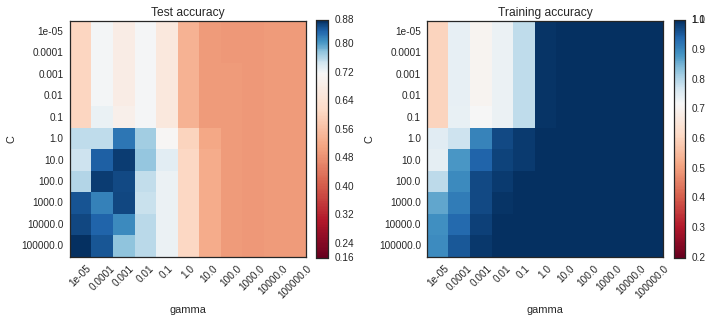

In [230]:
from matplotlib.colors import Normalize
from sklearn.svm import SVC

pr = np.arange(0,360,5)
Y = []
X = []
for k in pr:
    img_data1 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car1/obj23__'+str(k)+'.png'))
    img_data2 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/car2/obj100__'+str(k)+'.png'))
    #img_data3 = np.asarray(Image.open('/home/danny/Università/Data Science/Optimization Methods for Machine Learning/Homework3/class3/obj65__'+str(k)+'.png'))
    if k==0:
        im1 = img_data1
        im2 = img_data2
        #im3 = img_data3
    x1 = img_data1.ravel() 
    x2 = img_data2.ravel()
    #x3 = img_data3.ravel()
    X.append(x1)
    Y.append(1)  
    X.append(x2)
    Y.append(-1)   
    #X.append(x3)
    #Y.append(2)  
X = np.array(X,dtype = 'float32')
y = np.array(Y)
X_stan = preprocessing.scale(X)
pca = PCA(2)
X = pca.fit_transform(X_stan)

param_C = np.logspace(-5, 5, 11)
param_gamma = np.logspace(-5, 5, 11)
acctest = []
acctrain = []
accuracy = []
accuracytrain = []
time = []
kf1 = StratifiedKFold(y, n_folds=10,shuffle=True)
for tupla in itertools.product(param_C,param_gamma):
    C = tupla[0]
    gamma = tupla[1]
    acctest = []
    acctrain = []
    for train_index, test_index in kf1:
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = SVC(C=C,kernel='rbf',gamma=gamma, cache_size = 1400)
        start = timer()
        clf.fit(X_train, y_train)
        end = timer()
        time.append(end-start)
        traine = clf.score(X_train, y_train)
        teste = clf.score(X_test, y_test)
        acctrain.append(traine)
        acctest.append(teste)
    accuracy.append(sum(acctest)/len(acctest))
    accuracytrain.append(sum(acctrain)/len(acctrain))
    #accuracy.append(sum(acctrain)/len(acctrain))
    #accuracy.append((C,gamma))
print 'LIBSVM average time '+str(sum(time)/len(time)),'Maximum Test Accuracy '+str(max(accuracy))
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

accuracy = np.array(accuracy).reshape(len(param_C), len(param_gamma))

fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

plt.subplot(121)
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(accuracy, interpolation='nearest', cmap=plt.cm.RdBu,norm=MidpointNormalize(vmin=0.2, midpoint=0.72))
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(param_gamma)), param_gamma, rotation=45)
plt.yticks(np.arange(len(param_C)), param_C)
plt.title('Test accuracy')
plt.colorbar(fraction=0.046, pad=0.04)

accuracytrain = np.array(accuracytrain).reshape(len(param_C), len(param_gamma))
#plt.figure(figsize=(6, 6))
plt.subplot(122)
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(accuracytrain, interpolation='nearest', cmap=plt.cm.RdBu,norm=MidpointNormalize(vmin=0.2, midpoint=0.72))
plt.xlabel('gamma')
plt.ylabel('C')
plt.xticks(np.arange(len(param_gamma)), param_gamma, rotation=45)
plt.yticks(np.arange(len(param_C)), param_C)
plt.title('Training accuracy')
plt.colorbar(fraction=0.046, pad=0.04)
sns.set_style("white")
plt.tight_layout()
plt.show()        

From the figure we can see how is important find the right hyperparameters for the SVM ; infact in this case the model seems that is really sensible to choice of gamma, when is too high it is clear that we have overfitting, the model cannot generalize for low values of C also. With LIBSVM we have for example a good accuracy with C and gamma equals to 100 and 0.0001, the same set of best hyperparameters that we found before.

Finally we put together all the results from the various type of SVM : 

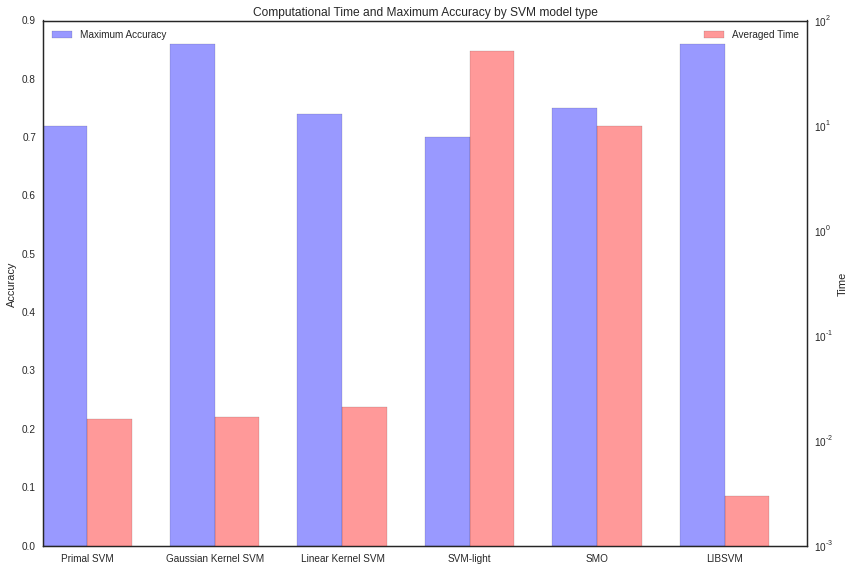

In [183]:
n_groups = 6

max_acc = (0.72, 0.86, 0.74, 0.70, 0.75,0.86)


time = (0.016, 0.017, 0.021, 51.21, 9.98,0.003)
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax2 = ax.twinx()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, max_acc, bar_width,
                 alpha=opacity,
                 color='b',
                 error_kw=error_config,
                 label='Maximum Accuracy')

rects2 = ax2.bar(index + bar_width, time, bar_width,
                 alpha=opacity,
                 color='r',
                 error_kw=error_config,
                 label='Averaged Time')

plt.xlabel('SVM Type')
ax.set_ylabel('Accuracy')
ax.legend(loc='upper left')
ax2.set_ylabel('Time')
ax2.set_yscale('log', nonposy='clip')
plt.title('Computational Time and Maximum Accuracy by SVM model type')
plt.xticks(index + bar_width, ('Primal SVM', 'Gaussian Kernel SVM', 'Linear Kernel SVM', 'SVM-light', 'SMO','LIBSVM'))
plt.legend()
sns.set_style("white")
plt.tight_layout()
plt.show()

The maximum accuracy of 86% is achieved both with LIBSVM (Gaussian kernel) and the SVM trained with CVXOPT (Gaussian kernel). We have seen that the dataset is not trivial to classify correcly, in fact all the linear methods don't obtain good accuracy. Also for the SVM-light and the SMO we have poor performance (both with the gaussian kernel) because decomposition  methods are less accurate but they can help a lot when we can't store the hessian in memory.
The fastest method is LIBSVM (using the same type of grid-search as the dual SVM) because by default use a shrinking heuristic, and the slowest are the two decomposition methods SVM-light and SMO respectively to 51 and 10 seconds.

In [3]:
%matplotlib inline
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [19]:
from IPython.core.display import HTML
HTML("""
<style>

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /*  Parts names nearer from text */
margin-bottom: -0.4em;
}


div.text_cell_render { /* Customize text cells */
font-family: 'Times New Roman';
font-size:1.5em;
line-height:1.4em;
padding-left:3em;
padding-right:3em;
}
</style>
""")